In [1]:
#Calling modules

In [2]:
import numpy
import os
import pdb
from subprocess import check_output
import sys
from vtk.util.numpy_support import vtk_to_numpy
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib import rc

sys.path.insert(0,'..')

import constants as c
from mesh import Mesh_2D_rm_sat
from mesh import Mesh_2D_cm_sat
from Boundaries.inner_2D_rectangular import Inner_2D_Rectangular
from Boundaries.outer_1D_rectangular import Outer_1D_Rectangular
from Boundaries.outer_2D_rectangular import Outer_2D_Rectangular
from Boundaries.outer_2D_cylindrical import Outer_2D_Cylindrical
from Boundaries.inner_2D_cylindrical import Inner_2D_Cylindrical

plt.rc('text', usetex=True)
plt.rc('axes', linewidth=1.5)
plt.rc('font', weight='bold')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

In [3]:
#Section from vtr_to_numpy

In [4]:
# This file provides methods to transform .vtr files into numpy arrays

def vtrToNumpy(mesh, filenames, names, directory = None):
    arrays = []
    #First filename
    if directory is None:
        #os.chdir(os.path.dirname(os.path.abspath('')))
        cwd = os.path.split(os.getcwd())[0]
        cwd = cwd+'/results/'
    else:
        cwd = directory
    filename = cwd + filenames[0]
    reader = mesh.vtkReader()
    reader.SetFileName(filename)
    reader.Update()
    output = reader.GetOutput()
    for name in names:
        temp = mesh.reverseVTKOrdering(vtk_to_numpy(output.GetPointData().GetArray(name)))
        temp = numpy.expand_dims(temp, axis = temp.ndim)
        arrays.append(temp)
    for filename in filenames[1:]:
        try:
            filename = cwd+filename
            reader = mesh.vtkReader()
            reader.SetFileName(filename)
            reader.Update()
            output = reader.GetOutput()
            for i in range(len(names)):
                temp = mesh.reverseVTKOrdering(vtk_to_numpy(output.GetPointData().GetArray(names[i])))
                temp = numpy.expand_dims(temp, axis = temp.ndim)
                arrays[i] = numpy.append(arrays[i], temp, axis = arrays[i].ndim-1)
        except:
            print("Filename:", filename)
            raise
    return arrays

def loadFromResults(files_id = '0-0', directory = None):
    #os.chdir(os.path.dirname(os.path.abspath('')))
    cwd = os.path.split(os.getcwd())[0]
    if directory is None:
        cwd = cwd+'/results/'
    else:
        cwd = directory
    stdout = check_output('ls' +' {}'.format(cwd), shell=True)
    files = stdout.decode().split(sep='\n')
    #files = list(filter(lambda x: '0-0-0-0_ts' in x, files)) 
    files = list(filter(lambda x: x.partition('_')[0] == files_id and 'ts' in x.partition('_')[2], files)) 
    return files


In [5]:
#Plots

In [6]:
#Plot functions
def mean_temperature_time(name, density, accDensity):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    data_d = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), density)
    data_acc = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), accDensity)
    data_d = [data_i-data_acc_i for data_i, data_acc_i in zip(data_d, data_acc)]
    for i in range(len(name)):
        d_loc = [numpy.flatnonzero(data_d[i][temp,j]) for j in range(numpy.shape(data_d[i])[1])]
        arr = [numpy.average(data[i][temp[d_loc[j]],j]) for j in range(numpy.shape(data[i])[1])]
        arr = [0 if numpy.isnan(x) else x for x in arr]
        time = numpy.arange(len(data[i][0,:]))*c.P_DT*10/1e-6
        plt.plot(time, arr, label = name[i])

    plt.title(r'\textbf{Average temperature in domain}', fontsize = 24)
    plt.ylabel(r'\textbf{Temperature [eV]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.yscale('log')
    plt.grid()
    plt.legend(fontsize = 20)
    #plt.ylim(5e1, 1.5e2)
    plt.legend()
    plt.show()

def mean_vel_time(name, density, accDensity, ind = None):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    data_d = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), density)
    data_acc = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), accDensity)
    data_d = [data_i-data_acc_i for data_i, data_acc_i in zip(data_d, data_acc)]
    for i in range(len(name)):
        if ind is None:
            ind = temp
        d_loc = [numpy.flatnonzero(data_d[i][ind,j]) for j in range(numpy.shape(data_d[i])[-1])]
        arr = [numpy.average(numpy.linalg.norm(data[i][ind[d_loc[j]],:,j], axis = 1)) for j in range(numpy.shape(data[i])[-1])]
        arr = [0 if numpy.isnan(x) else x for x in arr]
        time = numpy.arange(len(data[i][0,0,:]))*c.P_DT*10/1e-6
        plt.plot(time, arr, label = name[i])

    plt.title(r'\textbf{Average velocity in domain}', fontsize = 24)
    plt.ylabel(r'\textbf{Velocity [m/s]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def mean_density_time(name, accDensity):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    data_acc = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), accDensity)
    data = [data_i-data_acc_i for data_i, data_acc_i in zip(data, data_acc)]
    for i in range(len(name)):
        d_loc = [numpy.flatnonzero(data[i][temp,j]) for j in range(numpy.shape(data[i])[1])]
        arr = [numpy.average(data[i][temp[d_loc[j]],j]) for j in range(numpy.shape(data[i])[1])]
        arr = [0 if numpy.isnan(x) else x for x in arr]
        time = numpy.arange(len(data[i][0,:]))*c.P_DT*10/1e-6
        plt.plot(time, arr, label = name[i])

    plt.title(r'\textbf{Average density in domain}', fontsize = 24)
    plt.ylabel(r'\textbf{Density [m$^{-3}$]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def extremes_density_time(name):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    arr_min = numpy.min(data[1][temp]-data[0][temp], axis = 0)
    arr_max = numpy.max(data[1][temp]-data[0][temp], axis = 0)
    plt.plot(arr_min, label = 'min')
    plt.plot(arr_max, label = 'max')
    plt.legend()
    plt.show()

def current_collected_time(data, names):
    fig = plt.figure(figsize=(16,8))
    loc = numpy.unique(mesh.boundaries[1].location)
    for name in names:
        d_loc = [numpy.flatnonzero(data[name][loc,j]) for j in range(numpy.shape(data[name])[1])]
        arr = [numpy.sum(data[name][loc[d_loc[j]],j]*mesh.area_sat[d_loc[j]])/1e-3 for j in range(numpy.shape(data[name])[1])]
        arr = [0 if numpy.isnan(x) else x for x in arr]
        #plt.plot(numpy.sum(data[i][loc]*numpy.repeat(mesh.volumes[loc]/(mesh.dx/2), numpy.shape(data[i])[1], axis = 1), axis = 0), label = name[i])
        time = numpy.arange(len(data[name][0,:]))*c.P_DT*100/1e-6
        plt.plot(time, arr, label = name.replace('_', '\_'))

        avg = numpy.average(arr[int(2*len(arr)/3):])
        print("Average {} current is: {:.4e}".format(name,avg))
        plt.axhline(y = avg)

    plt.title(r'\textbf{Currents to/from satellite}', fontsize = 24)
    plt.ylabel(r'\textbf{Current [mA]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def current_recollection_percentage_time(data, names_out, names_in):
    fig = plt.figure(figsize=(16,8))
    loc = numpy.unique(mesh.boundaries[1].location)
    for name_out, name_in in zip(names_out, names_in):
        #Out
        d_loc = [numpy.flatnonzero(data[name_out][loc,j]) for j in range(numpy.shape(data[name_out])[1])]
        arr = [numpy.sum(data[name_out][loc[d_loc[j]],j]*mesh.area_sat[d_loc[j]])/1e-3 for j in range(numpy.shape(data[name_out])[1])]
        arr_out = [0 if numpy.isnan(x) else x for x in arr]
        arr_out = numpy.asarray(arr_out)
        #In
        d_loc = [numpy.flatnonzero(data[name_in][loc,j]) for j in range(numpy.shape(data[name_in])[1])]
        arr = [numpy.sum(data[name_in][loc[d_loc[j]],j]*mesh.area_sat[d_loc[j]])/1e-3 for j in range(numpy.shape(data[name_in])[1])]
        arr_in = [0 if numpy.isnan(x) else x for x in arr]
        arr_in = numpy.asarray(arr_in)
        #plt.plot(numpy.sum(data[i][loc]*numpy.repeat(mesh.volumes[loc]/(mesh.dx/2), numpy.shape(data[i])[1], axis = 1), axis = 0), label = name[i])
        time = numpy.arange(len(data[name_out][0,:]))*c.P_DT*100/1e-6
        plt.plot(time, numpy.abs(arr_in/arr_out)*100, label = name_out.replace('_', '\_'))

        avg = numpy.average(numpy.abs(arr_in/arr_out)[int(2*len(arr_in)/3):])*100
        print("Average {} percentage recollection is: {:.4e}".format(name_out,avg))
        plt.axhline(y = avg)

    plt.title(r'\textbf{Recolletion percentage satellite}', fontsize = 24)
    plt.ylabel(r'\textbf{Percentage of recollection}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def out_in_currents_collected_time(name_out, name_in):
    fig = plt.figure(figsize=(16,8))
    data_out = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name_out)
    data_in = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name_in)
    loc = numpy.unique(mesh.boundaries[1].location)
    for i in range(len(name_out)):
        d_loc_out = [numpy.flatnonzero(data_out[i][loc,j]) for j in range(numpy.shape(data_out[i])[1])]
        d_loc_in = [numpy.flatnonzero(data_in[i][loc,j]) for j in range(numpy.shape(data_in[i])[1])]
        arr_out = [numpy.sum(data_out[i][loc[d_loc_out[j]],j]*mesh.area_sat[d_loc_out[j]])/1e-3 for j in range(numpy.shape(data_out[i])[1])]
        arr_out = [0 if numpy.isnan(x) else x for x in arr_out]
        arr_in = [numpy.sum(data_in[i][loc[d_loc_in[j]],j]*mesh.area_sat[d_loc_in[j]])/1e-3 for j in range(numpy.shape(data_in[i])[1])]
        arr_in = [0 if numpy.isnan(x) else -x for x in arr_in]
        #plt.plot(numpy.sum(data[i][loc]*numpy.repeat(mesh.volumes[loc]/(mesh.dx/2), numpy.shape(data[i])[1], axis = 1), axis = 0), label = name[i])
        time = numpy.arange(len(data_out[i][0,:]))*c.P_DT*100/1e-6
        plt.plot(time, arr_out, label = name_out[i].replace('_', '\_'))
        plt.plot(time, arr_in, label = name_in[i].replace('_', '\_'))

    plt.title(r'\textbf{Currents to/from satellite}', fontsize = 24)
    plt.ylabel(r'\textbf{Current [mA]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

#NOTE: It only works for species that its charge is c.QE
def approx_velocity_wall(current, accDensity):
    fig = plt.figure(figsize=(16,8))
    data_c = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), current)
    data_acc = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), accDensity)
    loc = numpy.unique(mesh.boundaries[1].location)
    for i in range(len(current)):
        data_acc[i][:,1:] -= data_acc[i][:,:-1]
        d_loc = [numpy.flatnonzero(data_acc[i][loc,j] > 0) for j in range(numpy.shape(data_acc[i])[1])]
        arr = [numpy.average(data_c[i][loc[d_loc[j]],j]/c.QE/data_acc[i][loc[d_loc[j]],j]) for j in range(numpy.shape(data_c[i])[1])]
        arr = [0 if numpy.isnan(x) else abs(x) for x in arr]
        time = numpy.arange(len(data_c[i][0,:]))*c.P_DT*10/1e-6
        plt.plot(time, arr, label = current[i].replace('_','\_'))

    plt.title(r'\textbf{Average impact velocity to/from satellite}', fontsize = 24)
    plt.ylabel(r'\textbf{Velocity [m/s]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.yscale('log')
    plt.legend(fontsize = 20)
    plt.show()

    
def debye_function(x, *args):
    q0 = -c.QE*1.6e12*(c.YMAX-c.YMIN)/(c.NY-1)*(c.XMAX-c.XMIN)/(c.NX-1)*c.DEPTH
    return args[0]*1/4/numpy.pi/c.EPS_0*q0/abs(x)*numpy.exp(-abs(x)/args[1])

def debye_shielding_fit(x, y, guess):
    return optimize.curve_fit(debye_function,x,y, p0=guess)

def debye_length_test(name):
    fig = plt.figure(figsize=(16,8))
    #Preparing data
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    left = c.NX*(int(c.NY/2)+1)
    cut = data[0][left:left+c.NX,-1]
    x = numpy.linspace(c.XMIN, c.XMAX, num = c.NX)
    offset = (c.XMAX-c.XMIN)/2
    dx = (c.XMAX-c.XMIN)/(c.NX-1)
    #Omitting the center
    ind = numpy.where(numpy.logical_or(x < offset-4*dx, x > offset+4*dx))

    #Debye Lenght study
    lambda_d = 1/numpy.sqrt(c.E_N*c.QE*c.QE/c.EPS_0/c.K/c.E_T+c.P_N*c.QE*c.QE/c.EPS_0/c.K/c.P_T)
    print("Theory", lambda_d)
    theory = debye_function(x-offset, 1.0, lambda_d)
    guess = (1.0, lambda_d)
    params, errors = debye_shielding_fit(x[ind]-offset, cut[ind], guess)

    plt.plot(x, theory, color = 'black', label = 'Theory')
    plt.scatter(x, cut, color = 'red', marker = '.', label = 'Simulation')
    plt.plot(x, debye_function(x-offset, *params), color = 'blue', label = 'Fit')
    plt.legend()
    plt.show()

    #Further analysis
    fig = plt.figure(figsize=(16,8))
    val = []
    err = []
    for i in range(1,10):
        ind = numpy.where(numpy.logical_or(x < offset-i*dx, x > offset+i*dx))
        guess = (1.0, lambda_d)
        params, errors = debye_shielding_fit(x[ind]-offset, cut[ind], guess)
        val.append(params[1])
        err.append(numpy.sqrt(numpy.diag(errors)[1]))
        print(params, numpy.sqrt(numpy.diag(errors)))
    plt.axhline(y=lambda_d, color = 'black')
    plt.errorbar(numpy.arange(1,10), val, yerr=err, marker = '.', linestyle = '', ecolor = 'black')
    plt.show()

def wall_potential(name):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)[0]
    top = numpy.unique(mesh.boundaries[1].top)
    left = numpy.unique(mesh.boundaries[1].left)
    right = numpy.unique(mesh.boundaries[1].right)
    bottom = numpy.unique(mesh.boundaries[1].bottom)
    plt.plot(numpy.arange(len(top)), data[top,-1], label = 'top')
    plt.plot(numpy.arange(len(top)), data[left,-1], label = 'left')
    plt.plot(numpy.arange(len(top)), data[right,-1], label = 'right')
    plt.plot(numpy.arange(len(top)), data[bottom,-1], label = 'bottom')
    plt.title(r'\textbf{Potential at the different borders of the satellite}', fontsize = 24)
    plt.ylabel(r'\textbf{Potential [V]}', fontsize = 22)
    plt.xlabel(r'\textbf{Borders}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def satellite_potential_time(data, name, init_time = 0):
    fig = plt.figure(figsize=(16,8))
    sat = numpy.unique(mesh.boundaries[1].top)
    ind_sat = sat[0]
    time = numpy.arange(init_time, init_time+len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
    plt.plot(time, data[name][ind_sat,init_time:], label = "Satellite potential", color = 'black', linewidth = 1.5)
    if init_time == 0:
        ave = numpy.average(data[name][ind_sat,int(2/3*len(time)):])
    else:
        ave = numpy.average(data[name][ind_sat,init_time:])
    print("Average potential: ", ave)
    plt.axhline(y=ave, linewidth = 1.5, color = 'red')

    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    #plt.legend(fontsize = 20)
    plt.show()

def satellite_potential_FT(data, name, init_time = 115):
    fig = plt.figure(figsize=(16,8))
    sat = numpy.unique(mesh.boundaries[1].top)
    ind_sat = sat[0]
    #time = numpy.arange(len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
    pot = data[name][ind_sat,init_time:]
    #pot_trans = numpy.fft.fft(pot)
    pot_trans = numpy.fft.fft(pot-numpy.mean(pot))
    fs = 1/(c.E_DT*c.E_TS*c.VTK_TS)
    freq = numpy.arange(-fs/2, fs/2, fs/len(pot_trans))
    pot_trans = numpy.fft.fftshift(pot_trans)
    #(PRPnp.abs(numpy.fft.fft(signal,axis=axis)
    #plt.plot(freq, pot_trans.real, label = "Satellite potential-real")
    #plt.plot(freq, pot_trans.imag, label = "Satellite potential-imaginary")
    plt.plot(freq/1e6, 1/len(pot_trans)*numpy.abs(pot_trans), label = "Fourier Transform-magnitude", color = 'black',\
            linewidth=1.5)

    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.xlabel(r'\textbf{Frequency [MHz]}', fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    #plt.xlim(xmin=-0.01,xmax=numpy.max(freq/1e6))
    plt.xlim(xmin=-0.01,xmax=1.5)
    plt.grid()
    plt.legend(fontsize = 22)

    #fig = plt.figure(figsize=(16,8))
    #real_2 = pot_trans.real[1:int((len(freq)-1)/2)+1]+pot_trans.real[-1:int((len(freq)-1)/2):-1]
    #imag_2 = pot_trans.imag[1:int((len(freq)-1)/2)+1]-pot_trans.imag[-1:int((len(freq)-1)/2):-1]
    #plt.plot(freq[1:int((len(freq)-1)/2)+1], real_2, label = "Satellite potential-real")
    #plt.plot(freq[1:int((len(freq)-1)/2)+1], imag_2, label = "Satellite potential-imaginary")

    ##plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    #plt.ylabel(r'\textbf{Satellite Potential [V]}', fontsize = 22)
    #plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    #plt.tick_params(axis='both', which='major', labelsize=20)
    #plt.grid()
    #plt.legend(fontsize = 20)
    #plt.show()
    
def density_FT(data, name, init_time = 115, ind = 2040):
    fig = plt.figure(figsize=(16,8))
    #time = numpy.arange(len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
    pot = data[name][ind,init_time:]
    #pot_trans = numpy.fft.fft(pot)
    pot_trans = numpy.fft.fft(pot-numpy.mean(pot))
    #freq = numpy.fft.fftfreq(len(pot), d = c.E_DT*c.E_TS*c.VTK_TS)
    fs = 1/(c.E_DT*c.E_TS*c.VTK_TS)
    freq = numpy.arange(-fs/2, fs/2, fs/len(pot_trans))
    pot_trans = numpy.fft.fftshift(pot_trans)
    #(PRPnp.abs(numpy.fft.fft(signal,axis=axis)
    #plt.plot(freq, pot_trans.real, label = "Satellite potential-real")
    #plt.plot(freq, pot_trans.imag, label = "Satellite potential-imaginary")
    plt.plot(freq/1e6, 1/len(pot_trans)*numpy.abs(pot_trans), label = "Density-magnitude")

    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Density [1/m3]}', fontsize = 22)
    plt.xlabel(r'\textbf{Frequency [MHz]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

    #fig = plt.figure(figsize=(16,8))
    #real_2 = pot_trans.real[1:int((len(freq)-1)/2)+1]+pot_trans.real[-1:int((len(freq)-1)/2):-1]
    #imag_2 = pot_trans.imag[1:int((len(freq)-1)/2)+1]-pot_trans.imag[-1:int((len(freq)-1)/2):-1]
    #plt.plot(freq[1:int((len(freq)-1)/2)+1], real_2, label = "Satellite potential-real")
    #plt.plot(freq[1:int((len(freq)-1)/2)+1], imag_2, label = "Satellite potential-imaginary")

    ##plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    #plt.ylabel(r'\textbf{Satellite Potential [V]}', fontsize = 22)
    #plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    #plt.tick_params(axis='both', which='major', labelsize=20)
    #plt.grid()
    #plt.legend(fontsize = 20)
    #plt.show()
    
def densities_FT(data, name, init_time = 115, ind = [3965,2040, 8030, 13180]):
#def densities_FT(data, name, init_time = 115, ind = [13180]):

    fig = plt.figure(figsize=(16,8))
    #time = numpy.arange(len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
    for i in range(len(ind)):
        pot = data[name][ind[i],init_time:]
        time = numpy.arange(init_time, init_time+len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
        plt.plot(time, pot, label = "Density-{:d}".format(ind[i]))

    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Density [1/m3]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.ylim(ymin = 1e8, ymax = 1e10)
    plt.legend(fontsize = 20)
    plt.show()
    
    fig = plt.figure(figsize=(16,8))
    #time = numpy.arange(len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
    for i in range(len(ind)):
        pot = data[name][ind[i],init_time:]
        #pot_trans = numpy.fft.fft(pot)
        pot_trans = numpy.fft.fft(pot-numpy.mean(pot))
        #freq = numpy.fft.fftfreq(len(pot), d = c.E_DT*c.E_TS*c.VTK_TS)
        fs = 1/(c.E_DT*c.E_TS*c.VTK_TS)
        freq = numpy.arange(-fs/2, fs/2, fs/len(pot_trans))
        pot_trans = numpy.fft.fftshift(pot_trans)
        #(PRPnp.abs(numpy.fft.fft(signal,axis=axis)
        #plt.plot(freq, pot_trans.real, label = "Satellite potential-real")
        #plt.plot(freq, pot_trans.imag, label = "Satellite potential-imaginary")
        plt.plot(freq/1e6, 1/len(pot_trans)*numpy.abs(pot_trans), label = "Density-magnitude-{:d}".format(ind[i]))

    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Density [1/m3]}', fontsize = 22)
    plt.xlabel(r'\textbf{Frequency [MHz]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.xlim(xmin = -0.01, xmax = 1.5)
    plt.legend(fontsize = 20)
    plt.show()
    
def wall_density_diff(name):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    data = data[1]-data[0]
    top = numpy.unique(mesh.boundaries[1].top)
    left = numpy.unique(mesh.boundaries[1].left)
    right = numpy.unique(mesh.boundaries[1].right)
    bottom = numpy.unique(mesh.boundaries[1].bottom)
    plt.plot(numpy.arange(len(top)), data[top,-1], label = 'top')
    plt.plot(numpy.arange(len(top)), data[left,-1], label = 'left')
    plt.plot(numpy.arange(len(top)), data[right,-1], label = 'right')
    plt.plot(numpy.arange(len(top)), data[bottom,-1], label = 'bottom')
    plt.legend()
    plt.show()

def number_particles(data, names, spwts):
    fig = plt.figure(figsize=(16,8))
    for name, spwt in zip(names, spwts):
        d_loc = [numpy.flatnonzero(data[name][temp,j]) for j in range(numpy.shape(data[name])[1])]
        arr = [numpy.sum(data[name][temp[d_loc[j]],j]*mesh.volumes[temp[d_loc[j]]])/spwt for j in range(1, numpy.shape(data[name])[1])]
        arr = [0 if numpy.isnan(x) else x for x in arr]
        plt.plot(arr, label = name)
    plt.title(r'\textbf{Number of super particles}', fontsize = 24)
    plt.ylabel(r'\textbf{No. of SP}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def number_particles_per_cell(data, names, spwts):
    fig = plt.figure(figsize=(16,8))
    for name, spwt in zip(names, spwts):
        d_loc = [numpy.flatnonzero(data[name][temp,j]) for j in range(numpy.shape(data[name])[1])]
        arr = [numpy.min(data[name][temp[d_loc[j]],j]*mesh.volumes[temp[d_loc[j]]])/spwt for j in range(1, numpy.shape(data[name])[1])]
        arr = [0 if numpy.isnan(x) else x for x in arr]
        plt.plot(arr, label = name)
    plt.title(r'\textbf{Number of super particles per cell}', fontsize = 24)
    plt.ylabel(r'\textbf{No. of SP per cell}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

def increase_number_particles(name):
    fig = plt.figure(figsize=(16,8))
    data = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), name)
    for i in range(len(name)):
        arr = numpy.sum(data[i][temp]*mesh.volumes[temp][:,None], axis = 0)
        time = numpy.arange(len(arr[:-1]))*c.P_DT*10/1e-6
        plt.plot(time, arr[1:]-arr[:-1], label = name[i])
        #plt.plot(arr[1:]-arr[:-1], label = name[i])
    plt.axhline(y=3.310585e9, color = 'black', label='Photoelectron')
    plt.axhline(y=0, color = 'k')
    #plt.axhline(y=1.416000e11, color = 'red', label='electron-proton')
    plt.ylabel(r'\textbf{$\delta$ particles}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

#The arguments will be received as tuples, as many as the species entered, and each tuple will be (charge, density, temperature).
def debye_length(*args):
    lambda_d = numpy.zeros_like(args[0][1])
    for i in range(len(args)):
        lambda_d += args[i][0]*args[i][0]*args[i][1]/c.EPS_0/c.K/args[i][2]
    lambda_d = 1/numpy.sqrt(lambda_d)
    return lambda_d

def debye_length_analysis(density, accDensity, temperature,\
        proton_density = ["Proton - Solar wind-density"], proton_accDensity = ["Proton - Solar wind-accumulated density"], proton_temperature = ["Proton - Solar wind-temperature"], n = 20):
    dictionary = {}

    data_p_density = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), proton_density)
    data_p_acc = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), proton_accDensity)
    data_p_density = [data_i-data_acc_i for data_i, data_acc_i in zip(data_p_density, data_p_acc)][0]
    data_p_temperature = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), proton_temperature)[0]

    data_e_density = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), density)
    data_e_acc = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), accDensity)
    data_e_density = [data_i-data_acc_i for data_i, data_acc_i in zip(data_e_density, data_e_acc)]
    data_e_temperature = vtn.vtrToNumpy(mesh, vtn.loadFromResults(), temperature)

    #Average over the last n stored results
    ts = numpy.shape(data_p_density)[1]
    data_p_density = numpy.average(data_p_density[:,ts-n:], axis = 1)
    data_p_temperature = numpy.average(data_p_temperature[:,ts-n:], axis = 1)*c.EV_TO_K

    for i in range(len(density)):
        #Average over the last n stored results
        data_e_density_i = numpy.average(data_e_density[i][:,ts-n:], axis = 1)
        data_e_temperature_i = numpy.average(data_e_temperature[i][:,ts-n:], axis = 1)*c.EV_TO_K

        #Debye Length calcualtion
        lambda_d = debye_length((c.QE, data_e_density_i, data_e_temperature_i), (-c.QE, data_p_density, data_p_temperature))
        dictionary["Debye length - {}".format(density[i].rsplit("-", 1)[0])] = lambda_d

    #Create minimum Debye length case
    compact_l = list(dictionary.values())
    compact = reduce(lambda x, y: numpy.append(x, y[:,None], axis = 1), compact_l[1:], compact_l[0][:,None])
    compact = numpy.nanmin(compact, axis = 1)
    dictionary["Debye length - smallest"] = compact

    #Export to vtr files
    cwd = os.getcwd()
    vtkstring = os.path.join(cwd,'plotters','plots','debye_length')
    mesh.saveVTK(vtkstring, dictionary)

def surface_charge_density_time(data, names, charges):
    fig = plt.figure(figsize=(16,8))
    time = numpy.arange(len(data[names[0]][0,:]))*c.P_DT*100/1e-6
    loc = numpy.unique(mesh.boundaries[1].location)
    for name, charge in zip(names, charges):
        d_loc = [numpy.flatnonzero(data[name][loc,j]) for j in range(numpy.shape(data[name])[1])]
        arr = numpy.asarray([numpy.sum(data[name][loc[d_loc[j]],j])*charge/abs(charge) for j in range(numpy.shape(data[name])[1])])
        arr[numpy.isnan(arr)] = 0
        plt.plot(time, arr, label = name.replace('_','\_'))

    #avg = numpy.average(net[int(2*len(net)/3):])
    #print("Average density is: {:.4e} 1/m3".format(avg))
    #plt.axhline(y = avg)

    plt.title(r'\textbf{Accumulated surface charge density}', fontsize = 24)
    plt.ylabel(r'\textbf{Density (sign aware) [1/m$^{3}$]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.gca().ticklabel_format(axis='y', style='sci')
    plt.grid()
    plt.show()

def net_surface_charge_density_time(data, names, charges):
    fig = plt.figure(figsize=(16,8))
    loc = numpy.unique(mesh.boundaries[1].location)
    net = numpy.zeros((len(data[names[0]][0,:])))
    for name, charge in zip(names, charges):
        d_loc = [numpy.flatnonzero(data[name][loc,j]) for j in range(numpy.shape(data[name])[1])]
        arr = numpy.asarray([numpy.sum(data[name][loc[d_loc[j]],j])*charge/abs(charge) for j in range(numpy.shape(data[name])[1])])
        arr[numpy.isnan(arr)] = 0
        net += arr
    
    time = numpy.arange(len(data[names[0]][0,:]))*c.P_DT*100/1e-6
    plt.plot(time, net)

    avg = numpy.average(net[int(2*len(net)/3):])
    print("Average density is: {:.4e} 1/m3".format(avg))
    plt.axhline(y = avg)

    plt.title(r'\textbf{Accumulated surface charge density}', fontsize = 24)
    plt.ylabel(r'\textbf{Density (sign aware) [1/m$^{3}$]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.gca().ticklabel_format(axis='y', style='sci')
    plt.grid()
    plt.show()

def total_surface_charge_time(data, names, charges):
    fig = plt.figure(figsize=(16,8))
    loc = numpy.unique(mesh.boundaries[1].location)
    net = numpy.zeros((len(data[names[0]][0,:])))
    for name, charge in zip(names, charges):
        d_loc = [numpy.flatnonzero(data[name][loc,j]) for j in range(numpy.shape(data[name])[1])]
        arr = numpy.asarray([numpy.sum(data[name][loc[d_loc[j]],j]*charge*mesh.volumes[loc[d_loc[j]]]) for j in range(numpy.shape(data[name])[1])])
        arr[numpy.isnan(arr)] = 0
        net += arr
    
    time = numpy.arange(len(data[names[0]][0,:]))*c.P_DT*100/1e-6
    plt.plot(time, net)

    avg = numpy.average(net[int(2*len(net)/3):])
    print("Average charge is: {:.4e} C".format(avg))
    plt.axhline(y = avg)

    plt.title(r'\textbf{Total charge}', fontsize = 24)
    plt.ylabel(r'\textbf{Charge [C]}', fontsize = 22)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.gca().ticklabel_format(axis='y', style='sci')
    plt.grid()
    plt.show()

In [7]:
#---------------------------------------------------------------------------------------------------------------------
# Creating mesh
#---------------------------------------------------------------------------------------------------------------------
## 0-0-0-0
#outer = Outer_2D_Rectangular(7.0, 12.2, -2.6, 2.6, 'space')
#inner = Inner_2D_Rectangular(9.0, 10.2, -0.6, 0.6, 'satellite')
#mesh = Mesh_2D_rm_sat(7.0, 12.2, -2.6, 2.6, 9.0, 10.2, -0.6, 0.6, 0.02, 0.02, 1.2, [outer, inner])
#temp = numpy.arange(mesh.nPoints, dtype = numpy.uint32)
# 0-0-0
outer = Outer_2D_Cylindrical(5.0, 10.2, 0.0, 2.6, 'space')
inner = Inner_2D_Cylindrical(7.0, 8.2, 0.0, 0.6, 'satellite')
mesh = Mesh_2D_cm_sat(5.0, 10.2, 0.0, 2.6, 7.0, 8.2, 0.0, 0.6, 0.02, 0.02, [outer, inner])
temp = numpy.arange(mesh.nPoints, dtype = numpy.uint32)
#temp = numpy.delete(temp, numpy.append(mesh.boundaries[1].location, mesh.boundaries[1].ind_inner))
temp = numpy.delete(temp, mesh.boundaries[1].ind_inner)

##Establishing a minimum of superparticles for a cell
## The minimum of required population of super particles will be 2 particles at the center of a cell with the maximum volume in the mesh
#spwt_min = 2*c.E_SPWT*0.5*0.5/numpy.max(mesh.volumes)
spwt_min = 0

#---------------------------------------------------------------------------------------------------------------------
# Plotting functions
#---------------------------------------------------------------------------------------------------------------------

In [9]:
#---------------------------------------------------------------------------------------------------------------------
# Extracting data
#---------------------------------------------------------------------------------------------------------------------

data0 ={}
names = [\
        "Electric - Electrostatic_2D_cm_sat_cond-potential",\
        "Electron - Solar wind-density",\
        "Electron - Photoelectron-flux", "Electron - SEE-flux", "Electron - Solar wind-flux", "Proton - Solar wind-flux",\
        "Electron - Photoelectron-outgoing_flux", "Electron - SEE-outgoing_flux",\
        "Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"\
        ]
results = vtrToNumpy(mesh, loadFromResults(), names)
for name, array in zip(names, results):
    data0[name] = array

Average potential:  -14.45618822898569


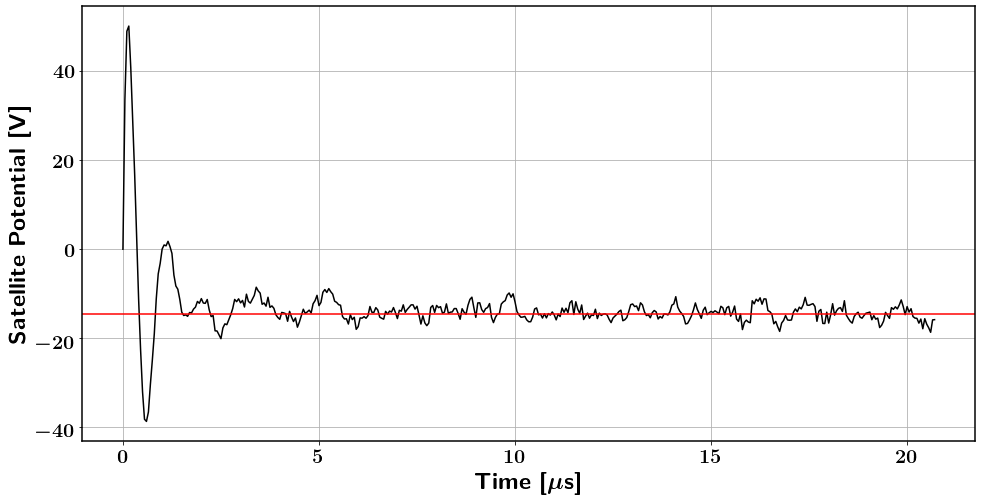

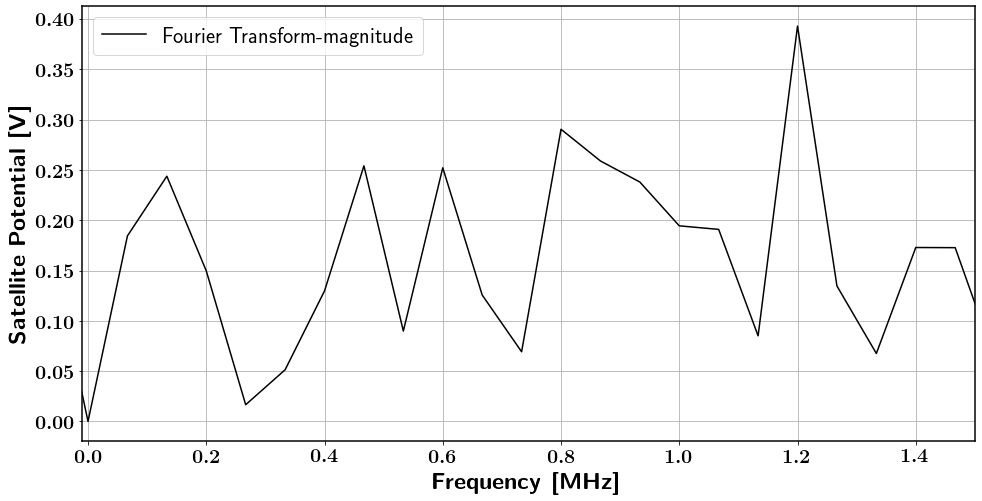

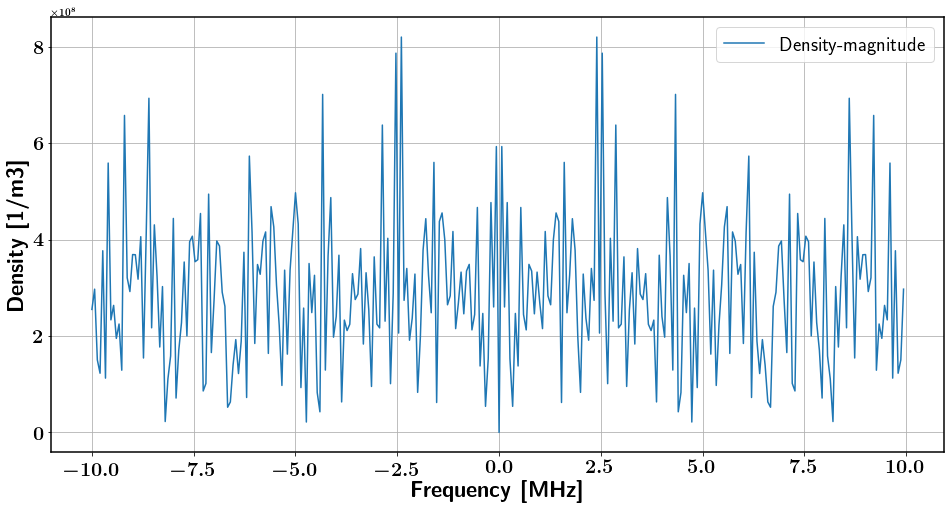

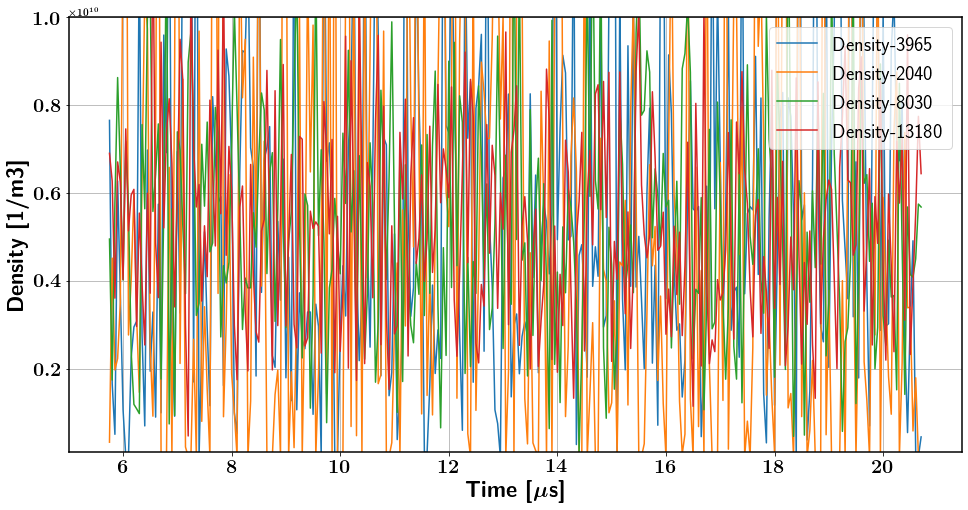

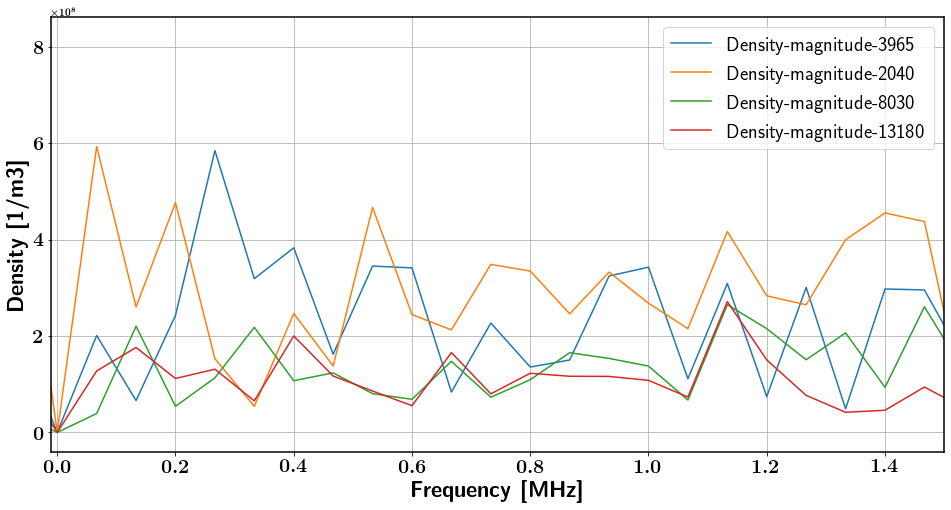

Average Electron - Photoelectron-flux current is: -1.5463e+01
Average Electron - SEE-flux current is: -1.6682e+01
Average Electron - Solar wind-flux current is: -8.8177e+00
Average Proton - Solar wind-flux current is: 5.7171e-01


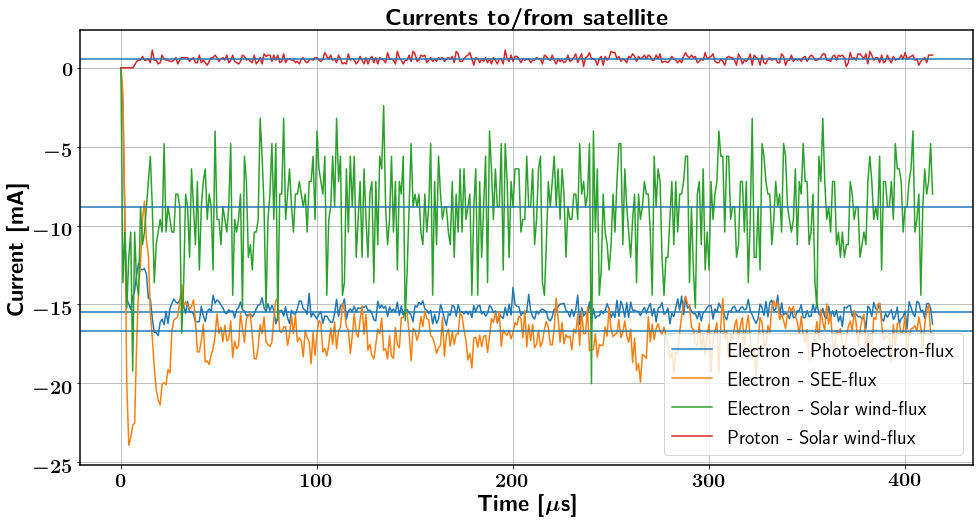

Average Electron - Photoelectron-outgoing_flux current is: 1.8250e+01
Average Electron - SEE-outgoing_flux current is: 2.2039e+01


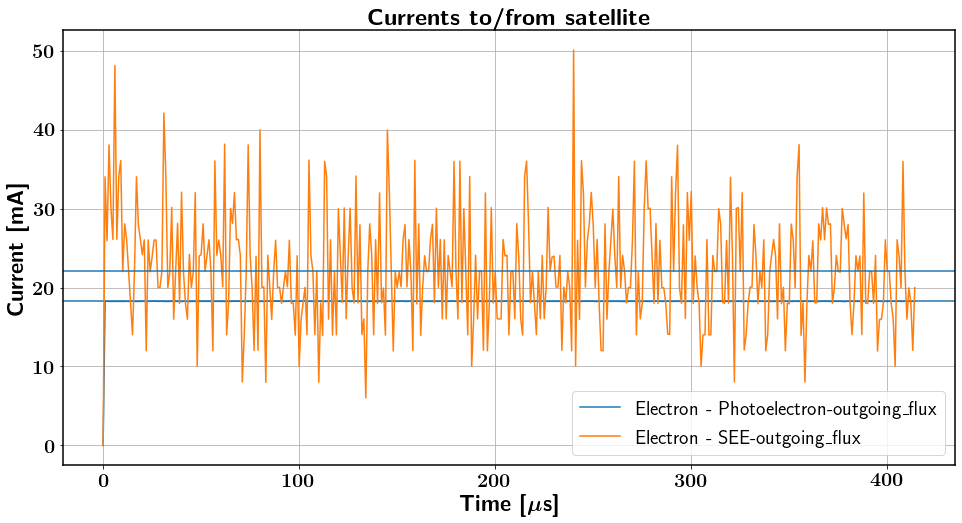

/home/jorge/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/jorge/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide
/home/jorge/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in true_divide
/home/jorge/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide


Average Electron - Photoelectron-outgoing_flux percentage recollection is: 8.4729e+01
Average Electron - SEE-outgoing_flux percentage recollection is: 8.3324e+01


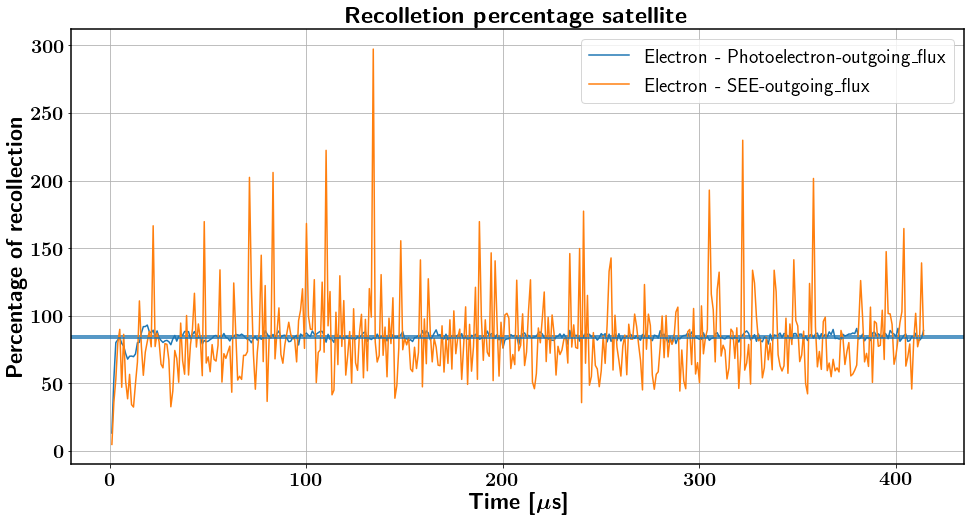

In [37]:
#---------------------------------------------------------------------------------------------------------------------
# Functions calls
#---------------------------------------------------------------------------------------------------------------------


#increase_number_particles(["Electron - Photoelectron-density"])
#increase_number_particles(["Electron - Photoelectron-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#                            [c.PHE_SPWT, c.E_SPWT, c.P_SPWT])
#extremes_density_time(["Electron - Solar wind-density", "Proton - Solar wind-density"])
#debye_length_analysis(["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density"],\
#                      ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density"],\
#                      ["Electron - Photoelectron-temperature", "Electron - SEE-temperature", "Electron - Solar wind-temperature"])
#mean_density_time(["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#                  ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"])
#number_particles(data, ["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#                 [c.PHE_SPWT, c.SEE_SPWT, c.E_SPWT, c.P_SPWT])
#number_particles_per_cell(data, ["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#                          [c.PHE_SPWT, c.SEE_SPWT, c.E_SPWT, c.P_SPWT])
#mean_temperature_time(["Electron - Photoelectron-temperature", "Electron - SEE-temperature", "Electron - Solar wind-temperature", "Proton - Solar wind-temperature"],\
#                      ["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#                      ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"])
#mean_vel_time(["Electron - Photoelectron-velocity", "Electron - SEE-velocity", "Electron - Solar wind-velocity", "Proton - Solar wind-velocity"],\
#              ["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#              ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"])
#mean_vel_time(["Electron - Photoelectron-velocity", "Electron - SEE-velocity", "Electron - Solar wind-velocity", "Proton - Solar wind-velocity"],\
#              ["Electron - Photoelectron-density", "Electron - SEE-density", "Electron - Solar wind-density", "Proton - Solar wind-density"],\
#              ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"],\
#              ind = numpy.unique(mesh.boundaries[1].location))
###debye_length_test(["Electric - Electrostatic_2D_rm-potential"])
#wall_potential(["Electric - Electrostatic_2D_rm_sat-potential"])
###wall_density_diff(["Electron - Solar wind-density", "Proton - Solar wind-density"])
satellite_potential_time(data2, "Electric - Electrostatic_2D_cm_sat_cond-potential", init_time = 0)
satellite_potential_FT(data2, "Electric - Electrostatic_2D_cm_sat_cond-potential")
density_FT(data2, "Electron - Solar wind-density")
densities_FT(data2, "Electron - Solar wind-density")
current_collected_time(data2, ["Electron - Photoelectron-flux", "Electron - SEE-flux", "Electron - Solar wind-flux", "Proton - Solar wind-flux"])
current_collected_time(data2, ["Electron - Photoelectron-outgoing_flux", "Electron - SEE-outgoing_flux"])
current_recollection_percentage_time(data2, ["Electron - Photoelectron-outgoing_flux", "Electron - SEE-outgoing_flux"],\
                                     ["Electron - Photoelectron-flux", "Electron - SEE-flux"])
##approx_velocity_wall(["Electron - Photoelectron-flux", "Electron - SEE-flux", "Electron - Solar wind-flux", "Proton - Solar wind-flux"],\
##                     ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"])
##approx_velocity_wall(["Electron - Photoelectron-outgoing_flux", "Electron - SEE-outgoing_flux"],\
##                     ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density"])
#out_in_currents_collected_time(["Electron - Photoelectron-outgoing_flux", "Electron - SEE-outgoing_flux"],\
#                               ["Electron - Photoelectron-flux", "Electron - SEE-flux"])
#surface_charge_density_time(["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"],\
#                            [c.QE, c.QE, c.QE, -c.QE])
#net_surface_charge_density_time(data, ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"],\
#                            [c.QE, c.QE, c.QE, -c.QE])
#total_surface_charge_time(data, ["Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"],\
#                            [c.QE, c.QE, c.QE, -c.QE])

In [8]:
#---------------------------------------------------------------------------------------------------------------------
# Extracting multiple data
#---------------------------------------------------------------------------------------------------------------------

names = [\
        "Electric - Electrostatic_2D_cm_sat_cond-potential",\
        "Electron - Solar wind-density",\
        "Electron - Photoelectron-flux", "Electron - SEE-flux", "Electron - Solar wind-flux", "Proton - Solar wind-flux",\
        "Electron - Photoelectron-outgoing_flux", "Electron - SEE-outgoing_flux",\
        "Electron - Photoelectron-accumulated density", "Electron - SEE-accumulated density", "Electron - Solar wind-accumulated density", "Proton - Solar wind-accumulated density"\
        ]

data1 ={}
directory1 = '/home/jorge/Documents/PHD/Simulations/SCSI/cases/results/2021_09_29/results/'
results = vtrToNumpy(mesh, loadFromResults(directory = directory1), names, directory = directory1)
for name, array in zip(names, results):
    data1[name] = array

data2 ={}
directory2 = '/home/jorge/Documents/PHD/Simulations/SCSI/cases/results/2021_09_20/results/'
results = vtrToNumpy(mesh, loadFromResults(directory = directory2), names, directory = directory2)
for name, array in zip(names, results):
    data2[name] = array



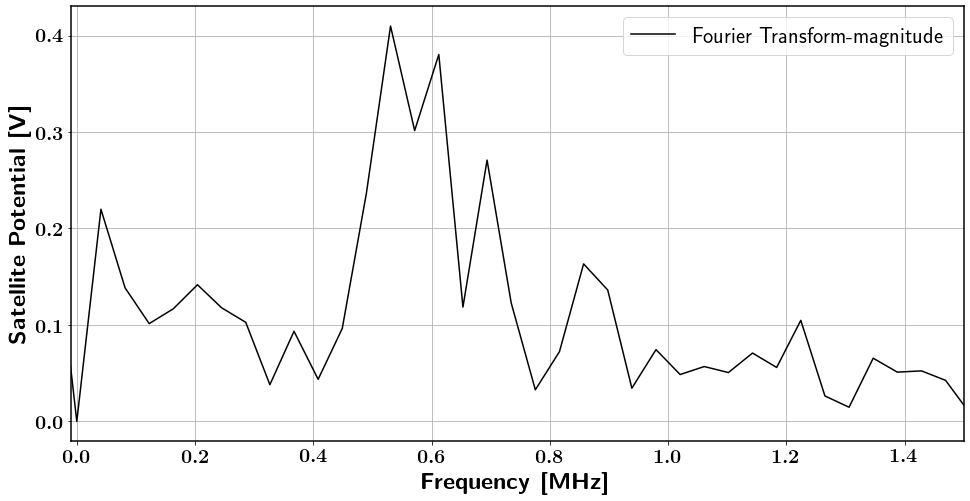

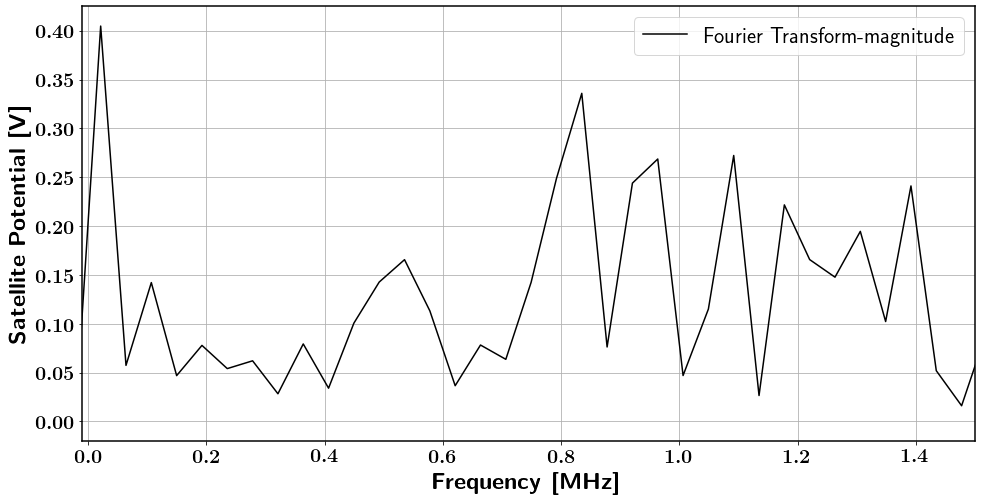

In [10]:
#satellite_potential_FT(data0, "Electric - Electrostatic_2D_cm_sat_cond-potential", init_time = 120)
satellite_potential_FT(data1, "Electric - Electrostatic_2D_cm_sat_cond-potential", init_time = 79)
satellite_potential_FT(data2, "Electric - Electrostatic_2D_cm_sat_cond-potential", init_time = 114)

In [75]:
def satellite_potentials_FT(data_p, name, init_time_p, colors = ['dimgray', 'skyblue', 'red']):
    fig = plt.figure(figsize=(16,8))
    sat = numpy.unique(mesh.boundaries[1].top)
    ind_sat = sat[0]
    numbers = range(len(data_p))
    #time = numpy.arange(len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
    for data, init_time, color, number in zip(data_p, init_time_p, colors, numbers):
        pot = data[name][ind_sat,init_time:]
        #pot_trans = numpy.fft.fft(pot)
        pot_trans = numpy.fft.fft(pot-numpy.mean(pot))
        length = len(pot_trans)
        fs = 1/(c.E_DT*c.E_TS*30)
        freq = numpy.arange(-fs/2, fs/2, fs/length)
        pot_trans = numpy.fft.fftshift(pot_trans)
    #(PRPnp.abs(numpy.fft.fft(signal,axis=axis)
    #plt.plot(freq, pot_trans.real, label = "Satellite potential-real")
    #plt.plot(freq, pot_trans.imag, label = "Satellite potential-imaginary")
        plt.plot(freq/1e6, 1/length*numpy.abs(pot_trans), label = number, color = color)
        ind = numpy.argmax(numpy.abs(pot_trans[int(length/2):]))
        print("id", "Frequency [MHz]", "Amplitude", "Phase")
        print(number, freq[int(length/2):][ind]/1e6, \
              1/length*numpy.abs(pot_trans[int(length/2):][ind]), numpy.angle(pot_trans[int(length/2):][ind]))
        plt.axvline(x=freq[int(length/2):][ind]/1e6, color = 'red')

    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Satellite Potential [V]}', fontsize = 22)
    plt.xlabel(r'\textbf{Frequency [MHz]}', fontsize = 22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlim(xmin=-0.02,xmax=3.0)
    #plt.xlim(xmin=0.65,xmax=0.95)
    plt.grid()
    plt.legend(fontsize = 20)
    plt.show()

id Frequency [MHz] Amplitude Phase
0 0.898692810457483 0.2613628772254201 0.3711300944042616
id Frequency [MHz] Amplitude Phase
1 0.07936507936526276 0.3967511795853964 -1.4437478830890242


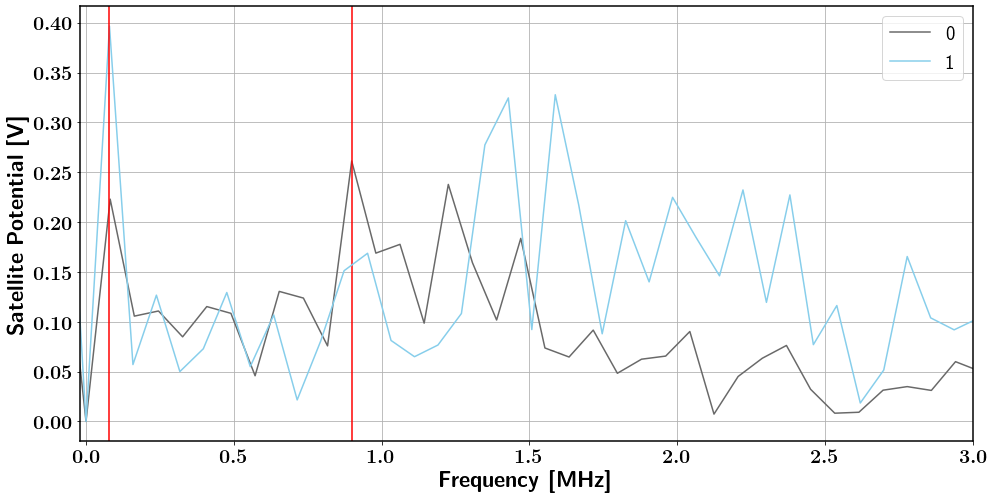

In [142]:
satellite_potentials_FT([data1, data2], "Electric - Electrostatic_2D_cm_sat_cond-potential", [161,161])

Average potential:  -14.40459894349064
Average potential:  -14.260956484224812


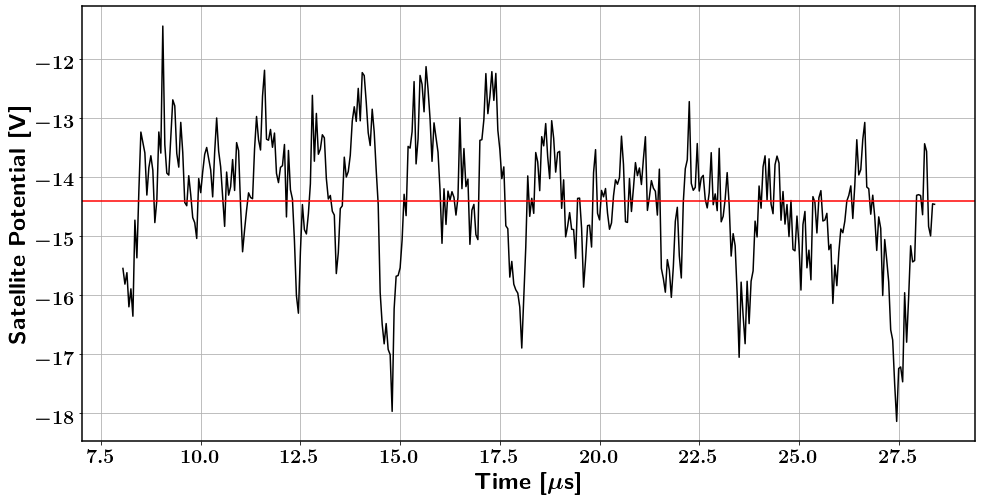

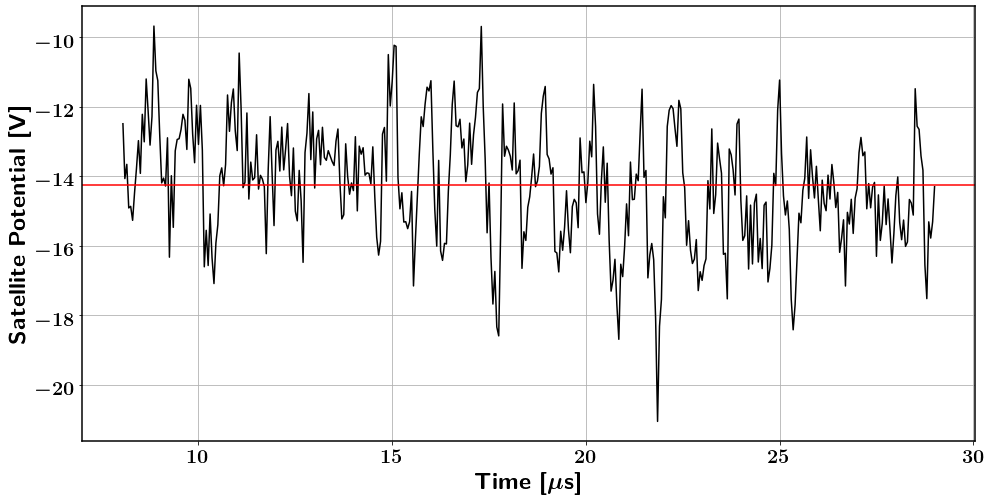

In [143]:
satellite_potential_time(data1, "Electric - Electrostatic_2D_cm_sat_cond-potential", init_time = 161)
satellite_potential_time(data2, "Electric - Electrostatic_2D_cm_sat_cond-potential", init_time = 161)

In [144]:
def satellite_potentials_time(data_p, name, init_time_p, colors = ['dimgray', 'firebrick', 'red']):
    fig = plt.figure(figsize=(16,8))
    sat = numpy.unique(mesh.boundaries[1].top)
    ind_sat = sat[0]
    numbers = range(len(data_p))
    for data, init_time, color, number in zip(data_p, init_time_p, colors, numbers):
        time = numpy.arange(init_time, init_time+len(data[name][0,init_time:]))*c.E_DT*c.E_TS*c.VTK_TS/1e-6
        plt.plot(time, data[name][ind_sat,init_time:], label = str(number), color = color, linewidth = 1.5)
        if init_time == 0:
            ave = numpy.average(data[name][ind_sat,int(2/3*len(time)):])
        else:
            ave = numpy.average(data[name][ind_sat,init_time:])
        print("Average potential: ", ave)
        plt.axhline(y=-14.40459894349064, linewidth = 1.5, color = 'red')
    
    avg = -14.40459894349064
    #r = 0.4031577085470106
    r = 0.225
    w = 0.07936507936526276e6
    phase = -1.4437478830890242
    pot1 =  r*numpy.cos(2*numpy.pi*w*time*1e-6+phase)
    #plt.plot(time,avg + r*numpy.cos(2*numpy.pi*w*time*1e-6+phase), label = "{:f}MHz component".format(w/1e6), color = 'black')
    
    avg = -14.40459894349064
    r = 0.2613628772254201
    w = 0.898692810457483e6
    phase = 0.3711300944042616
    #plt.plot(time,avg + r*numpy.cos(2*numpy.pi*w*time*1e-6+phase), label = "{:f}MHz component".format(w/1e6), color = 'blue')
    plt.plot(time,avg + r*numpy.cos(2*numpy.pi*w*time*1e-6+phase)+pot1, \
             label = "Combined", color = 'blue')
    

    #plt.ylim(ymin = -16, ymax = -12)
    #plt.xlim(xmax = 10)
    
    #plt.title(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.ylabel(r'\textbf{Satellite Potential [V]}', fontsize = 24)
    plt.xlabel(r'\textbf{Time [$\mu$s]}', fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize = 22)
    plt.grid()
    #plt.legend(fontsize = 20)

Average potential:  -14.07902268341075


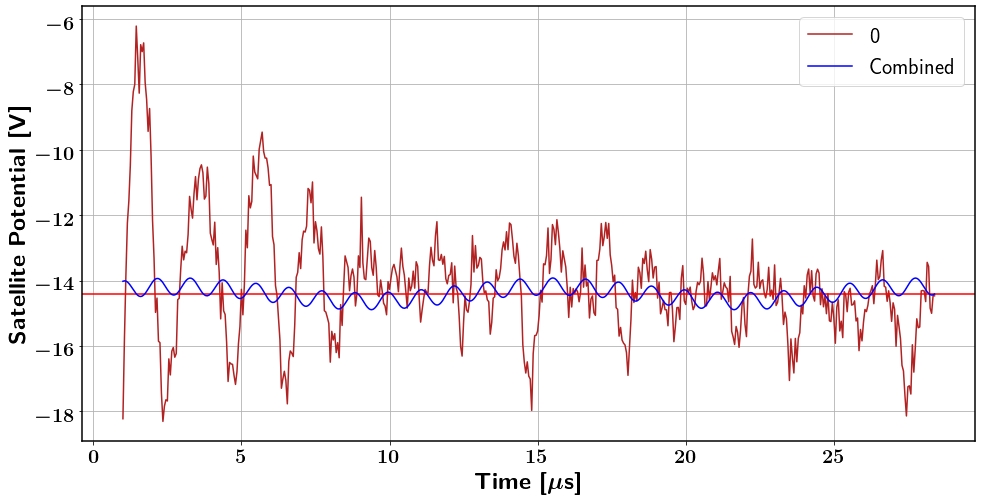

In [145]:
#satellite_potentials_time([data1,data2],"Electric - Electrostatic_2D_cm_sat_cond-potential", [161,161])
satellite_potentials_time([data1],"Electric - Electrostatic_2D_cm_sat_cond-potential", [20], colors = ['firebrick'])

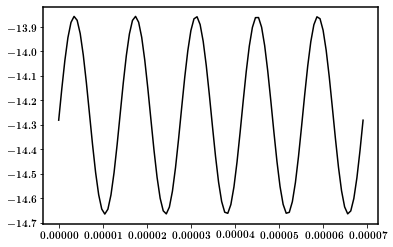

Period in microseconds  86.70795723923948


In [115]:
avg = -14.260956484224812
r = 0.4031577085470106
w = 0.07246376811580732e6
phase = -1.6210858687663705
time = numpy.linspace(0,1/w*5, num = 100)
plt.plot(time,avg + r*numpy.cos(2*numpy.pi*w*time+phase), label = "{:f}MHz component".format(w/1e6), color = 'black')
plt.show()
print("Period in microseconds ", 2*numpy.pi/w*1e6)